In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, Model

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Load the dataset
data = pd.read_csv('data1.csv')

# Drop unnecessary columns if any
data = data.dropna()  # Drop rows with missing values

# Separate features and labels
X = data.drop(columns=['label'])  # Features
y = data['label']  # Target

# Encode target if it's categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for Transformer Input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [6]:
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Transformer Encoder Block
    x = layers.MultiHeadAttention(num_heads=4, key_dim=32)(inputs, inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.3)(x)
    
    # Feed Forward Network (FFN)
    x_ffn = layers.Dense(128, activation="relu")(x)
    x_ffn = layers.Dropout(0.3)(x_ffn)
    x_ffn = layers.Dense(64, activation="relu")(x_ffn)
    
    # Add Residual Connection
    x = layers.Add()([x, x_ffn])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Flatten and Dense Layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    # Output Layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)  # Connect the output to the previous layer
    
    return Model(inputs, outputs)


In [7]:
input_shape = (X_train.shape[1], 1)
num_classes = len(np.unique(y_train))

# Initialize the model
model = build_transformer_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 1)     │        897 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 1)     │          2 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 15, 1)     │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 15, 128)   │        256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 15, 128)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 15, 64)    │      8,256 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 15, 64)    │          0 │ dropout_5[0][0],  │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 960)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │    123,008 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 46)        │      5,934 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 138,481 (540.94 KB)

 Trainable params: 138,481 (540.94 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

callbacks = [early_stopping, reduce_lr]


In [9]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.0367 - loss: 3.7559 - val_accuracy: 0.0425 - val_loss: 3.6561 - learning_rate: 0.0010
Epoch 2/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.0408 - loss: 3.6455 - val_accuracy: 0.0425 - val_loss: 3.6376 - learning_rate: 0.0010
Epoch 3/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.0408 - loss: 3.6329 - val_accuracy: 0.0425 - val_loss: 3.6353 - learning_rate: 0.0010
Epoch 4/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.0408 - loss: 3.6312 - val_accuracy: 0.0425 - val_loss: 3.6351 - learning_rate: 0.0010
Epoch 5/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - accuracy: 0.0408 - loss: 3.6310 - val_accuracy: 0.0425 - val_loss: 3.6351 - learning_rate: 0.0010
Epoch 6/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.0408 - loss: 3.6310 - val_accuracy: 0.0425 - val_loss: 3.6351 - learning_rate: 0.0010
Epoch 7/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accura

In [10]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 3.6283
Test Accuracy: 0.0401


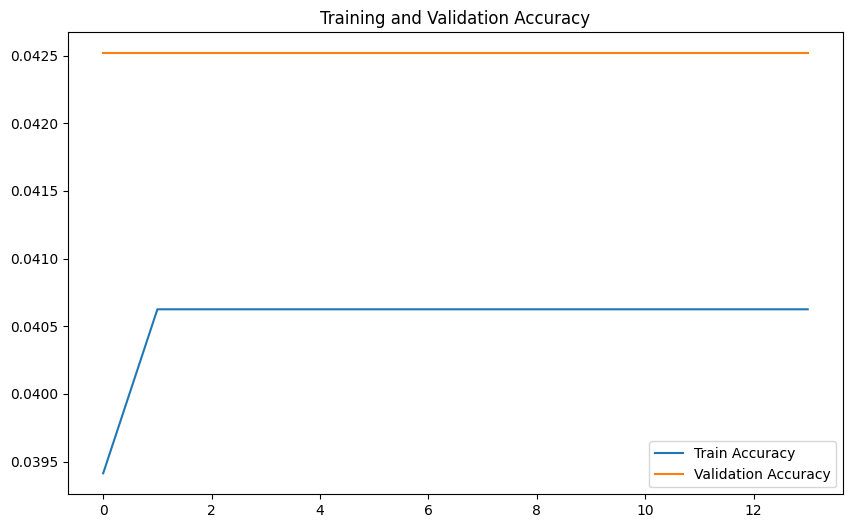

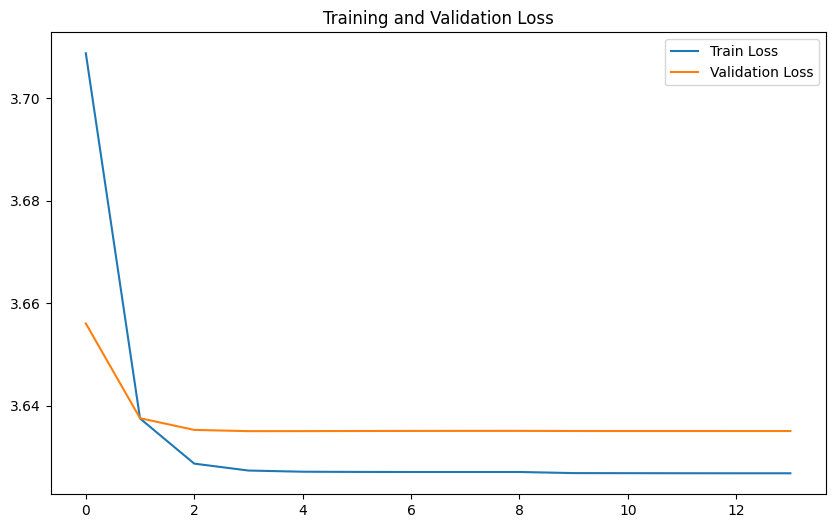

In [11]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# Predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Compare predictions with actual values
print("Predicted Classes:", predicted_classes[:10])
print("Actual Classes:", y_test[:10])

460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Predicted Classes: [11 11 11 11 11 11 11 11 11 11]
Actual Classes: [45  2  7 26 27 36 39 45 27 36]
